In [1]:
# -*- coding: utf-8 -*-
# Author: JoeBuzh

import os
import sys
import warnings
from datetime import datetime,timedelta

import xlrd
import xlwt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
# 图片设置
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# 解决中文显示问题
if sys.platform == 'darwin':
    plt.rcParams['font.sans-serif']=['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
pd.__version__

'1.0.3'

In [3]:
INDEX = 'CODMn'

In [4]:
data_dir = '../output'
train_file = '洛宁长水4h验证原始数据-线性扩展.xls'
valid_file = '大乌江4h验证原始数据-线性扩展.xls'
test_file = '沿江渡4h验证原始数据-线性扩展.xls'

In [5]:
def read_data(absfile):
    """ Read Raw Data """
    assert os.path.exists(absfile)

    return pd.read_excel(absfile,
        names=[
            'Time', 'Temp', 'pH', 'DO', 'Elecon', 'Turbidity', 'CODMn', 'NH3N', 'TP', 'TN'
        ])

In [6]:
""" 读取数据 """
train_data = read_data(os.path.join(data_dir, train_file))
valid_data = read_data(os.path.join(data_dir, valid_file))
test_data = read_data(os.path.join(data_dir, test_file))

In [8]:
test_data.sample()

,Time,Temp,pH,DO,Elecon,Turbidity,CODMn,NH3N,TP,TN
166,2020-06-22 16:00:00,27.9,8.95,19.78,342.5,5.7,3.48,0.062,0.043,2.74


+ 相关性

In [11]:
test_data[['NH3N', 'TN', 'TP', 'CODMn']].corr()

,NH3N,TN,TP,CODMn
NH3N,1.000000,0.485131,-0.105768,-0.343903
TN,0.485131,1.000000,-0.392090,-0.535821
TP,-0.105768,-0.392090,1.000000,0.860311
CODMn,-0.343903,-0.535821,0.860311,1.000000


In [12]:
valid_data[['NH3N', 'TN', 'TP', 'CODMn']].corr()

,NH3N,TN,TP,CODMn
NH3N,1.000000,0.062359,-0.334186,0.040392
TN,0.062359,1.000000,0.208204,0.592442
TP,-0.334186,0.208204,1.000000,0.042533
CODMn,0.040392,0.592442,0.042533,1.000000


In [13]:
train_data[['NH3N', 'TN', 'TP', 'CODMn']].corr()

,NH3N,TN,TP,CODMn
NH3N,1.000000,-0.191108,0.497609,0.492718
TN,-0.191108,1.000000,0.047672,0.046837
TP,0.497609,0.047672,1.000000,0.536979
CODMn,0.492718,0.046837,0.536979,1.000000


In [8]:
train_data.shape, valid_data.shape, test_data.shape

((3889, 10), (472, 10), (472, 10))

In [9]:
""" 间序列完备 """
train_len = pd.date_range('2018-11-1 00', '2020-8-10 00', freq='4h').shape[0]
valid_len = pd.date_range('2020-5-26 00', '2020-8-12 12', freq='4h').shape[0]
test_len = pd.date_range('2020-5-26 00', '2020-8-12 12', freq='4h').shape[0]
train_len, valid_len, test_len

(3889, 472, 472)

In [8]:
abs(
    train_data[['CODMn', 'NH3N', 'TN', 'TP']].diff(1)
).describe(percentiles=[.01, .02, .03, .05, .9, .95, .97, .99]).T

,count,mean,std,min,1%,2%,3%,5%,50%,90%,95%,97%,99%,max
CODMn,3888.0,0.097081,0.133593,0.0,0.0,0.0,0.000253,0.000789,0.042143,0.265,0.3580,0.434340,0.62639,1.280
NH3N,3888.0,0.002080,0.004305,0.0,0.0,0.0,0.000000,0.000000,0.001000,0.005,0.0080,0.011000,0.01800,0.058
TN,3888.0,0.022033,0.040013,0.0,0.0,0.0,0.000000,0.000047,0.008000,0.049,0.1103,0.155390,0.21100,0.372
TP,3888.0,0.001503,0.003075,0.0,0.0,0.0,0.000000,0.000000,0.000500,0.004,0.0070,0.009524,0.01500,0.035


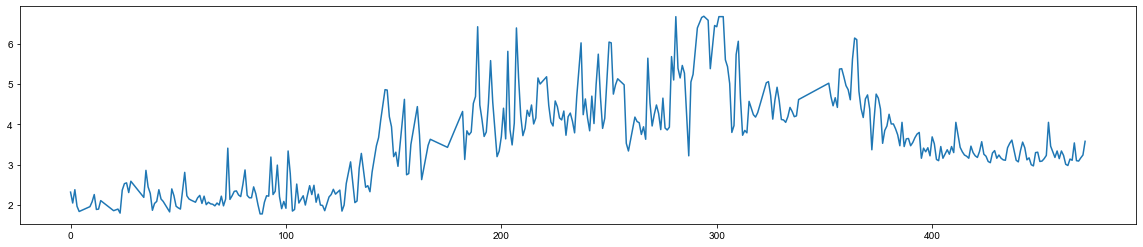

In [7]:
test_data[INDEX].plot(figsize=(20, 4))   # 非平稳数据

## FbProphet

In [8]:
temp = test_data[['Time', INDEX]].rename(columns={'Time': 'ds', INDEX: 'y'})
temp

,ds,y
0,2020-05-26 00:00:00,2.32
1,2020-05-26 04:00:00,2.05
2,2020-05-26 08:00:00,2.38
3,2020-05-26 12:00:00,1.97
4,2020-05-26 16:00:00,1.84
...,...,...
467,2020-08-11 20:00:00,3.10
468,2020-08-12 00:00:00,3.09
469,2020-08-12 04:00:00,3.17
470,2020-08-12 08:00:00,3.24


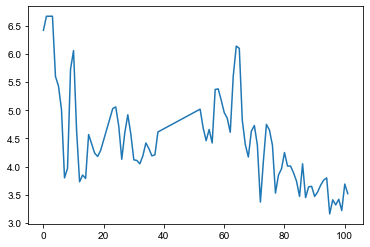

In [45]:
his = temp.loc[(temp.ds>='2020-07-15 00:00:00')&(temp.ds<'2020-08-01 00:00:00')].reset_index(drop=True)
his.y.plot()

In [46]:
# std
std = StandardScaler().fit(his['y'].values.reshape(-1, 1))
his['y'] = std.transform(his['y'].values.reshape(-1, 1))
his

,ds,y
0,2020-07-15 00:00:00,2.493542
1,2020-07-15 04:00:00,2.818102
2,2020-07-15 08:00:00,2.818102
3,2020-07-15 12:00:00,2.818102
4,2020-07-15 16:00:00,1.428986
...,...,...
97,2020-07-31 04:00:00,-1.531000
98,2020-07-31 08:00:00,-1.401176
99,2020-07-31 12:00:00,-1.660824
100,2020-07-31 16:00:00,-1.050651


In [11]:
# log
his['y'] = np.log(his['y'])
his

,ds,y
0,2020-07-01 00:00:00,-2.847312
1,2020-07-01 04:00:00,-2.645075
2,2020-07-01 08:00:00,-2.577022
3,2020-07-01 12:00:00,-2.621873
4,2020-07-01 16:00:00,-2.668829
...,...,...
181,2020-07-31 04:00:00,-3.244194
182,2020-07-31 08:00:00,-3.296837
183,2020-07-31 12:00:00,-3.324236
184,2020-07-31 16:00:00,-3.194183


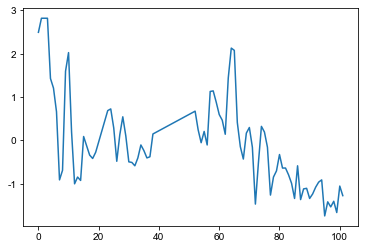

In [47]:
his['y'].plot()

In [48]:
# fbprorhet
from fbprophet import Prophet

m = Prophet()
m.fit(his)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [49]:
future = m.make_future_dataframe(periods=42, freq='4h')
future

,ds
0,2020-07-15 00:00:00
1,2020-07-15 04:00:00
2,2020-07-15 08:00:00
3,2020-07-15 12:00:00
4,2020-07-15 16:00:00
...,...
139,2020-08-07 04:00:00
140,2020-08-07 08:00:00
141,2020-08-07 12:00:00
142,2020-08-07 16:00:00


In [50]:
# predict
forecast_fb = m.predict(future)

In [52]:
forecast_real = forecast_fb[['yhat_lower', 'yhat_upper', 'yhat']].apply(lambda x: std.inverse_transform(x))
forecast_real['ds'] = forecast_fb['ds']
forecast_real

,yhat_lower,yhat_upper,yhat,ds
0,4.668480,6.076250,5.339647,2020-07-15 00:00:00
1,4.531209,6.023130,5.317343,2020-07-15 04:00:00
2,4.656385,6.132968,5.395214,2020-07-15 08:00:00
3,4.966135,6.404181,5.673134,2020-07-15 12:00:00
4,4.994577,6.472019,5.701537,2020-07-15 16:00:00
...,...,...,...,...
139,1.969075,3.358222,2.665861,2020-08-07 04:00:00
140,2.011347,3.481702,2.762229,2020-08-07 08:00:00
141,2.422080,3.852508,3.108857,2020-08-07 12:00:00
142,2.552218,4.019722,3.252049,2020-08-07 16:00:00


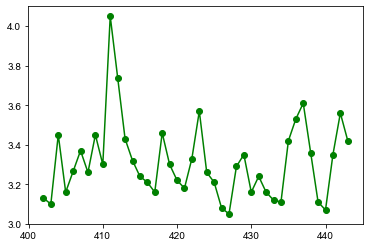

In [53]:
plt.plot(test_data[INDEX].loc[(test_data.Time>='2020-08-01 00:00:00')&(test_data.Time<='2020-08-07 20:00:00')], color='g', marker='o')

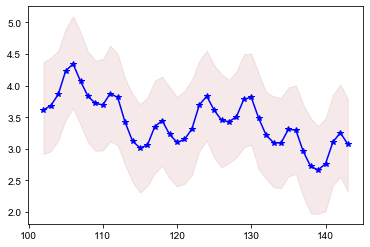

In [59]:
plt.plot(forecast_real.loc[(forecast_real.ds>='2020-08-01 00:00:00')&(forecast_real.ds<='2020-08-07 20:00:00')]['yhat'], color='b', marker='*')
plt.fill_between(
    forecast_real.loc[(forecast_real.ds>='2020-08-01 00:00:00')&(forecast_real.ds<='2020-08-07 20:00:00')]['yhat'].index,
    forecast_real.loc[(forecast_real.ds>='2020-08-01 00:00:00')&(forecast_real.ds<='2020-08-07 20:00:00')]['yhat_lower'],
    forecast_real.loc[(forecast_real.ds>='2020-08-01 00:00:00')&(forecast_real.ds<='2020-08-07 20:00:00')]['yhat_upper'],
    color='brown',
    alpha=0.1
)

In [60]:
from sklearn.metrics import r2_score

r2_score(
    test_data.loc[(test_data.Time>='2020-08-01 00:00:00')&(test_data.Time<='2020-08-07 20:00:00')][INDEX],
    forecast_real.loc[(forecast_real.ds>='2020-08-01 00:00:00')&(forecast_real.ds<='2020-08-07 20:00:00')]['yhat']
)

-3.4581319918826283

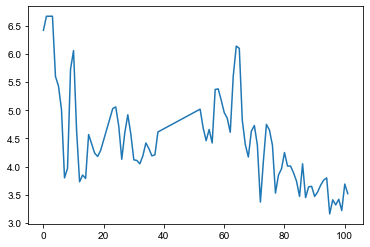

In [55]:
plt.plot(std.inverse_transform(his.y))

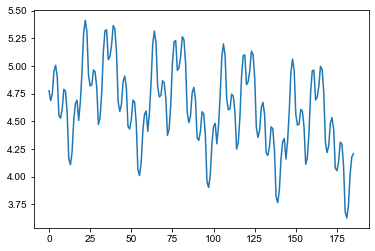

In [33]:
forecast_real.loc[(forecast_real.ds>='2020-07-01 00:00:00')&(forecast_real.ds<'2020-08-01 00:00:00')]['yhat'].plot()

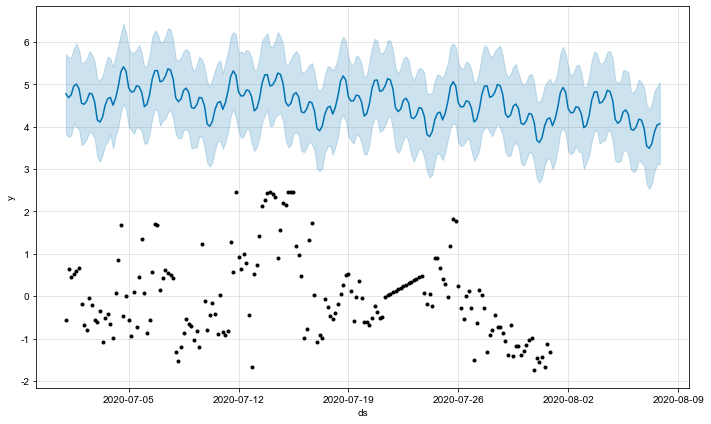

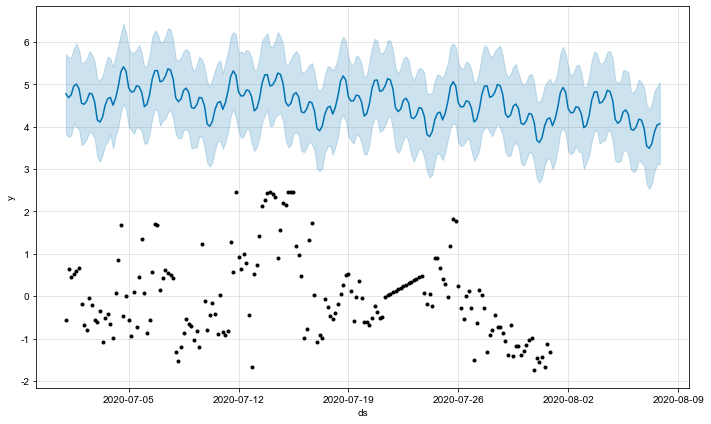

In [29]:
m.plot(forecast_real)

## ARIMA

```
生成 ARIMA 模型的基本步骤：

1. 对序列绘图，进行 ADF 检验，观察序列是否平稳；对于非平稳时间序列要先进行 d 阶差分，转化为平稳时间序列；
2. 经过第一步处理，已经得到平稳时间序列。要对平稳时间序列分别求得其自相关系数（ACF）和偏自相关系数（PACF），
   通过对自相关图和偏自相关图的分析，得到最佳的阶数p、q；
3. 由以上得到的d、q、p ，得到 ARIMA 模型。然后开始对得到的模型进行模型检验。
```

In [10]:
from scipy import stats
import statsmodels.api as sm                            # 一阶自相关性检验
from statsmodels.tsa.arima_model import ARIMA, ARMA     # ARIMA & ARMA
from statsmodels.tsa.seasonal import seasonal_decompose # 序列分解
from statsmodels.tsa.stattools import adfuller as ADF   # 平稳性检验
from statsmodels.graphics.tsaplots import plot_acf      # ACF
from statsmodels.graphics.tsaplots import plot_pacf     # PACF
from statsmodels.graphics.api import qqplot             # 检验残差服从正太分布
from statsmodels.stats.diagnostic import acorr_ljungbox # 白噪声检验

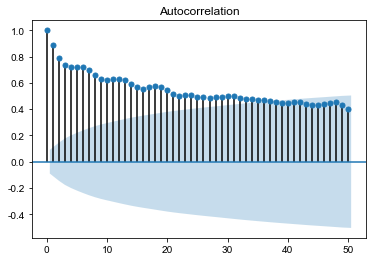

In [11]:
plot_acf(test_data[INDEX], lags=50).show()
# 自相关系数长期大于零，没有趋向于零，说明序列间具有很强的长期相关性。

In [12]:
def decompose(data: pd.DataFrame) -> tuple:
    """ STL时间序列分解 """
    decomposition = seasonal_decompose(data)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    return trend, seasonal, residual

In [13]:
def decompose_plot(group: list):
    plt.figure(figsize=(16, 12))
    for i, (data, name) in enumerate(group):
        plt.subplot(4, 1, i+1)
        plt.plot(data, label=name)
        plt.legend(loc='best')
    plt.show()

In [14]:
# define test data & decompose
temp = test_data[['Time', INDEX]].set_index('Time')

In [15]:
temp_train = temp[:'2020-08-05 12:00:00']
temp_test = temp['2020-08-05 16:00:00':]
temp.shape, temp_train.shape, temp_test.shape

((472, 1), (430, 1), (42, 1))

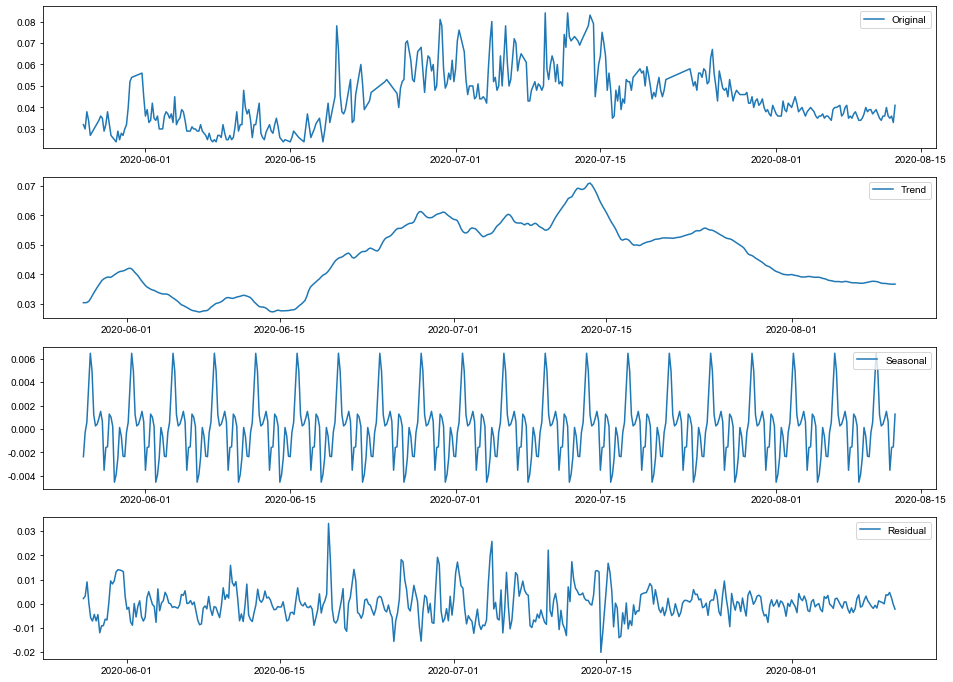

In [16]:
trend, seasonal, residual = decompose(temp)
group = [(temp, 'Original'), (trend, 'Trend'), (seasonal, 'Seasonal'), (residual, 'Residual')]
decompose_plot(group)

In [17]:
def diff_adf(data: pd.DataFrame) -> int:
    """ ADF检验 -> d """
    # diff & fillna
    data_diff1 = data.diff(1).fillna(0.0)
    data_diff2 = data.diff(1).diff(1).fillna(0.0)
    # adf
    data_adf = ADF(data[INDEX].tolist())
    data_diff1_adf = ADF(data_diff1[INDEX].tolist())
    data_diff2_adf = ADF(data_diff2[INDEX].tolist())
    # get p
    p = 0
    for i, adf in enumerate([data_adf, data_diff1_adf, data_diff2_adf]):
        t_val, p_val, _, _, ts, _ = adf
        if t_val < min(ts.values()):
            p = i
            print('p={}\nadf={}'.format(i, adf))
            break
        else:
            p += i
    # plot
    plt.figure(figsize=(20, 5))
    plt.plot(data, label='Original', color='blue')
    plt.plot(data_diff1, label='Diff1', color='red')
    plt.plot(data_diff2, label='Diff2', color='green')
    plt.legend(loc='best')
    plt.title("{} Value".format(INDEX))
    plt.show()

    return p

+ T检验假设检验值
+ P-value
+ Lags used
+ 使用的观测样本的数量
+ 不同程度拒绝原假设的统计值

#### 如何确定该序列是否平稳呢？
 1. 1%、%5、%10不同程度拒绝原假设的统计值和 ADF 假设检验值比较，ADF 假设检验值同时小于1%、5%、10%即说明非常好地拒绝该假设。
+ **第一个数据与1%、5%、10%比较，是否小于后者们？**
 2. P-value是否非常接近0。
+ **第二个数据是否非常接近0, 远小于0.05**


```
第一个  adf检验的结果。 
第二个  统计量的P值。 
第三个  计算过程中用到的延迟阶数。 
第四个  用于ADF回归和计算的观测值的个数。 
第五个  配合第一个一起看的，是在99%，95%，90%置信区间下的临界的ADF检验的值。
```

In [18]:
ADF(temp_train)
# P值大于显著性水平α（0.05），接受原假设（非平稳序列），说明原始序列是非平稳序列。

(-2.5653170391611835,
 0.10037947018259613,
 5,
 424,
 {'1%': -3.445867291195605,
  '5%': -2.868380822100627,
  '10%': -2.5704139268867925},
 -2984.8542172705033)

In [19]:
ADF(temp_train.diff(1).dropna())

(-14.223378347519322,
 1.6431073336875586e-26,
 4,
 424,
 {'1%': -3.445867291195605,
  '5%': -2.868380822100627,
  '10%': -2.5704139268867925},
 -2971.8522355487303)

p=1
adf=(-14.246234198805476, 1.5078405451108414e-26, 4, 425, {'1%': -3.445830555854264, '5%': -2.8683646683004276, '10%': -2.570405316262976}, -2979.8921083862683)


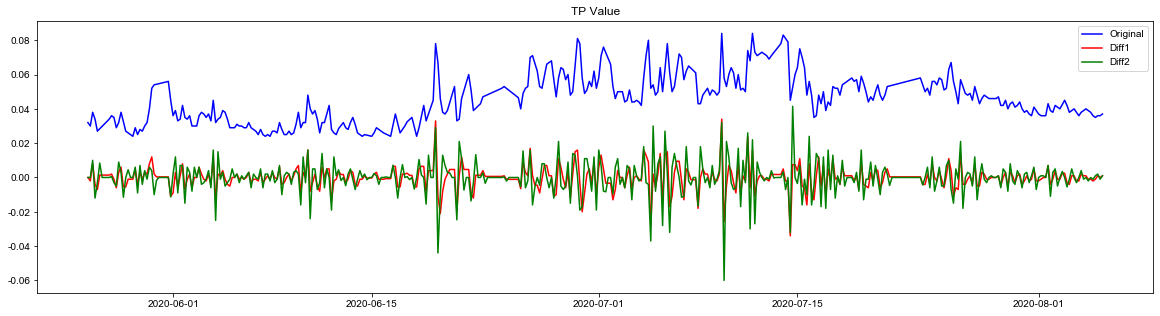

In [20]:
p = diff_adf(temp_train)

In [21]:
# 一阶差分序列的白噪声检验结果
# 返回统计量、P值
# p值小于0.05，拒绝原假设（纯随机序列），说明一阶差分序列是非白噪声。
acorr_ljungbox(temp_train, lags=1)  # lags=1 一阶

(array([337.41250795]), array([2.33553606e-75]))

### ACF & PACF 图像
```
如何确定 AR（p）的 p 值，MA（q）的 q 值？

拖尾和截尾
拖尾指序列以指数率单调递减或震荡衰减，而截尾指序列从某个时点变得非常小
```

```
从序列 ACF 、PACF 的图中没有发现明显的拖尾或截尾，说明对于这样的序列，并不适合用ARIMA 模型来拟合。
如何用 ARIMA 模型来拟合这样的曲线呢？
这里我们将先通过对时间序列分解（STL），再采用 ARIMA 模型来拟合趋势序列与残差序列。
```

+ Raw
 1. 确定了一阶差分后，观测差分后的acf&pacf

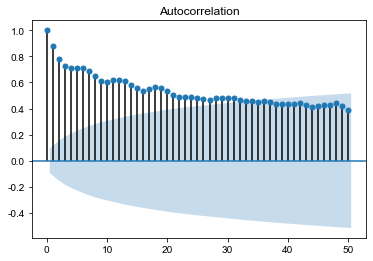

In [23]:
# ACF -> q -> MA
plot_acf(temp_train, lags=50).show()

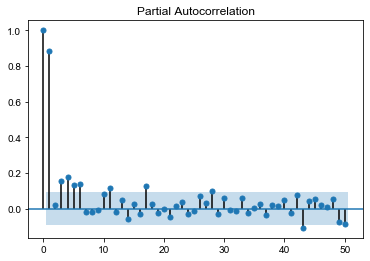

In [24]:
# PACF -> p -> AR
plot_pacf(temp_train, lags=50).show()

+ Diff1

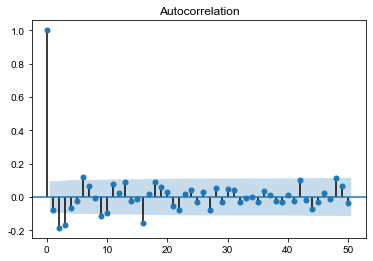

In [25]:
plot_acf(temp_train.diff(1).dropna(), lags=50).show()

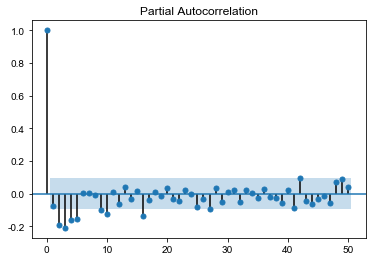

In [26]:
plot_pacf(temp_train.diff(1).dropna(), lags=50).show()

In [27]:
def get_order(data):
    """ 获取最佳 p & q """
    res = sm.tsa.arma_order_select_ic(
        data,
        ic=['bic'],
        trend='nc',
        max_ar=6,
        max_ma=6
    )
    print(res.bic_min_order)

    return res.bic_min_order

In [28]:
p, q = get_order(temp_train)

/Users/joe/miniconda3/envs/3clear_ecflow/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/joe/miniconda3/envs/3clear_ecflow/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/joe/miniconda3/envs/3clear_ecflow/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 1)


In [28]:
# Model Define
def ARIMA_model(data, order):
    """ ARIMA """
    model = ARIMA(data, order=order)

    return model.fit(disp=-1, method='css')

def ARMA_model(data, order):
    """ ARMA """
    model = ARMA(data, order=order)

    return model.fit(disp=-1, method='css')

In [54]:
arima = ARIMA_model(temp_train.dropna(), (6, 1, 3))

/Users/joe/miniconda3/envs/3clear_ecflow/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  % freq, ValueWarning)
/Users/joe/miniconda3/envs/3clear_ecflow/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  % freq, ValueWarning)
/Users/joe/miniconda3/envs/3clear_ecflow/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [31]:
arma = ARMA_model(temp_train.diff(1).dropna(), (2, 1))

/Users/joe/miniconda3/envs/3clear_ecflow/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  % freq, ValueWarning)


In [34]:
arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   NH3N   No. Observations:                  429
Model:                     ARMA(2, 1)   Log Likelihood                1232.070
Method:                           css   S.D. of innovations              0.014
Date:                Fri, 28 Aug 2020   AIC                          -2454.140
Time:                        10:53:41   BIC                          -2433.856
Sample:                    05-26-2020   HQIC                         -2446.128
                         - 08-05-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.837      0.066   -1.42e-05       0.000
ar.L1.NH3N     0.5347      0.055      9.724      0.000       0.427       0.642
ar.L2.NH3N     0.0750      0.052      1.451      0.147      -0.026       0.176
ma.L1.NH3N    -0.9324      0.025    -36.633      0.000      -0.982      -0.883
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5382           +0.0000j            1.5382            0.0000
AR.2           -8.6658           +0.0000j            8.6658            0.5000
MA.1            1.0725           +0.0000j            1.0725            0.0000
-----------------------------------------------------------------------------
"""

In [32]:
arima.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARIMA
====================================================================
Model:              ARIMA            BIC:                 -3038.3470
Dependent Variable: D.TP             Log-Likelihood:      1549.4    
Date:               2020-08-28 11:00 Scale:               1.0000    
No. Observations:   429              Method:              css       
Df Model:           9                Sample:              05-27-2020
Df Residuals:       415                                   08-05-2020
Converged:          1.0000           S.D. of innovations: 0.006     
No. Iterations:     332.0000         HQIC:                -3062.844 
AIC:                -3078.8443                                      
----------------------------------------------------------------------
              Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
----------------------------------------------------------------------
const         0.0000     0.0001    0.1086   0.9135   -0.0002    0.0002
ar.L1.D.TP    0.6143     0.4874    1.2604   0.2075   -0.3410    1.5696
ar.L2.D.TP   -1.0639     0.3740   -2.8445   0.0044   -1.7970   -0.3308
ar.L3.D.TP    0.3966     0.5088    0.7796   0.4356   -0.6005    1.3938
ar.L4.D.TP   -0.1751     0.0573   -3.0569   0.0022   -0.2874   -0.0628
ar.L5.D.TP   -0.0625     0.1485   -0.4209   0.6738   -0.3536    0.2286
ma.L1.D.TP   -0.8122     0.4863   -1.6700   0.0949   -1.7654    0.1410
ma.L2.D.TP    0.9335     0.4408    2.1177   0.0342    0.0695    1.7975
ma.L3.D.TP   -0.6159     0.4213   -1.4617   0.1438   -1.4417    0.2099
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1            0.0298            -1.1055           1.1059            -0.2457
AR.2            0.0298             1.1055           1.1059             0.2457
AR.3            1.0245            -1.2704           1.6321            -0.1420
AR.4            1.0245             1.2704           1.6321             0.1420
AR.5           -4.9103            -0.0000           4.9103            -0.5000
MA.1            0.0572            -1.0749           1.0764            -0.2415
MA.2            0.0572             1.0749           1.0764             0.2415
MA.3            1.4015            -0.0000           1.4015            -0.0000
====================================================================

"""

+ 残差检验

In [55]:
resid = arima.resid

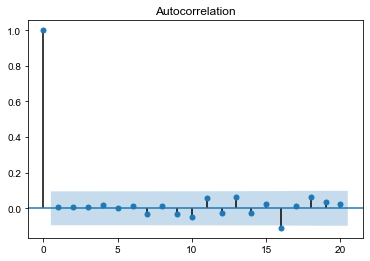

In [56]:
plot_acf(resid, lags=20).show() # 有短期相关性，但趋向于零

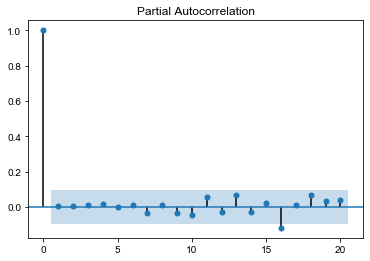

In [57]:
plot_pacf(resid, lags=20).show()

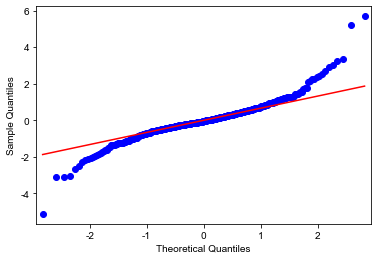

In [58]:
""" QQ图 """
# 残差服从正态分布，均值为零，方差为常数
qqplot(resid, line='q', fit=True).show()

+ D-W检验

```
德宾-沃森检验,简称D-W检验，是目前检验自相关性最常用的方法，但它只适用于检验一阶自相关性。 因为自相关系数ρ的值介于-1和1之间，所以 0≤DW≤４。

并且DW＝O ＜ ＝＞ ρ＝１　　即存在正自相关性
DW＝４ ＜＝＞ ρ＝－１　即存在负自相关性
DW＝２ ＜＝＞ ρ＝０　　即不存在（一阶）自相关性
因此，当DW值显著的接近于O或４时，则存在自相关性，而接近于２时，则不存在（一阶）自相关性。

原文链接：https://blog.csdn.net/u010414589/article/details/49622625
```

In [59]:
sm.stats.durbin_watson(resid.values)

1.9890628912895636

+ Ljung-Box检验

```
Ljung-Box test是对randomness的检验,或者说是对时间序列是否存在滞后相关的一种统计检验。
对于滞后相关的检验，我们常常采用的方法还包括计算ACF和PCAF并观察其图像，但是无论是ACF还是PACF都仅仅考虑是否存在某一特定滞后阶数的相关。
LB检验则是基于一系列滞后阶数，判断序列总体的相关性或者说随机性是否存在。 时间序列中一个最基本的模型就是高斯白噪声序列。
而对于ARIMA模型，其残差被假定为高斯白噪声序列，所以当我们用ARIMA模型去拟合数据时，拟合后我们要对残差的估计序列进行LB检验，判断其是否是高斯白噪声，如果不是，那么就说明ARIMA模型也许并不是一个适合样本的模型。

检验的结果就是看最后一列前十二行的检验概率（一般观察滞后1~12阶），如果检验概率小于给定的显著性水平，比如0.05、0.10等就拒绝原假设，其原假设是相关系数为零。

原文链接：[https://blog.csdn.net/u010414589/article/details/49622625]
```

In [60]:
acorr_ljungbox(resid,lags=1)

(array([0.01071073]), array([0.91757199]))

#### Predict & Forecast

In [62]:
temp_train.head()

,TP
Time,
2020-05-26 00:00:00,0.032
2020-05-26 04:00:00,0.030
2020-05-26 08:00:00,0.038
2020-05-26 12:00:00,0.034
2020-05-26 16:00:00,0.027


In [63]:
temp_test.head()

,TP
Time,
2020-08-05 16:00:00,0.035
2020-08-05 20:00:00,0.036
2020-08-06 00:00:00,0.036
2020-08-06 04:00:00,0.035
2020-08-06 08:00:00,0.034


In [64]:
arima.forecast(42)[0].shape, temp_test.shape

((42,), (42, 1))

In [144]:
temp.head()

,NH3N
Time,
2020-05-26 00:00:00,0.027000
2020-05-26 04:00:00,0.022000
2020-05-26 08:00:00,0.017000
2020-05-26 12:00:00,0.023000
2020-05-26 16:00:00,0.021333


In [65]:
arima.fittedvalues

Time
2020-05-27 04:00:00   -0.002226
2020-05-27 08:00:00   -0.002239
2020-05-27 12:00:00   -0.001506
2020-05-27 16:00:00   -0.002602
2020-05-27 20:00:00   -0.003396
                         ...   
2020-08-04 20:00:00    0.000004
2020-08-05 00:00:00    0.000825
2020-08-05 04:00:00    0.001544
2020-08-05 08:00:00    0.001403
2020-08-05 12:00:00    0.000887
Length: 423, dtype: float64

In [66]:
arima.predict(start='2020-05-27 04:00:00', end='2020-08-05 12:00:00', typ='levels')

2020-05-27 04:00:00    0.027574
2020-05-27 08:00:00    0.028961
2020-05-27 12:00:00    0.031094
2020-05-27 16:00:00    0.031398
2020-05-27 20:00:00    0.032604
                         ...   
2020-08-04 20:00:00    0.038004
2020-08-05 00:00:00    0.036825
2020-08-05 04:00:00    0.036544
2020-08-05 08:00:00    0.037403
2020-08-05 12:00:00    0.036887
Freq: 4H, Length: 423, dtype: float64

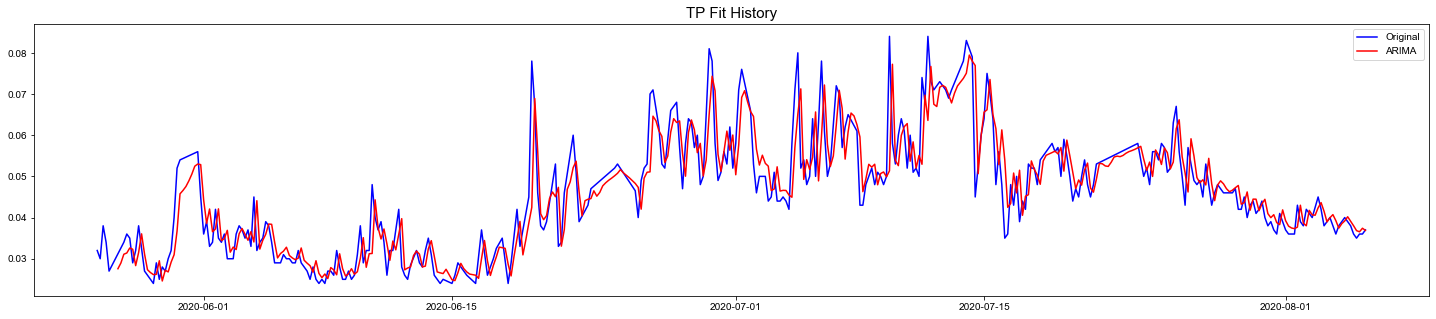

In [67]:
""" Fit Curve """
plt.figure(figsize=(25, 5))
plt.plot(temp_train, label='Original', color='blue')
plt.plot(arima.predict(start='2020-05-27 04:00:00', end='2020-08-05 12:00:00', typ='levels'), label='ARIMA', color='red')
# plt.title('{}历史数据拟合情况'.format(INDEX))
plt.legend(loc='best')
plt.title('{} Fit History'.format(INDEX), fontsize=15)
plt.show()

In [72]:
arima.forecast(42)[0]

array([0.03735569, 0.03739719, 0.03734729, 0.03751111, 0.03771128,
       0.03789551, 0.03803167, 0.03810543, 0.03813744, 0.03818557,
       0.03826242, 0.03833957, 0.03839684, 0.0384372 , 0.0384704 ,
       0.03850423, 0.03854186, 0.03858051, 0.0386153 , 0.03864495,
       0.03867199, 0.03869899, 0.03872661, 0.03875416, 0.03878077,
       0.03880612, 0.03883063, 0.03885491, 0.03887926, 0.03890356,
       0.03892758, 0.03895125, 0.03897468, 0.038998  , 0.0390213 ,
       0.03904456, 0.03906774, 0.03909083, 0.03911384, 0.0391368 ,
       0.03915975, 0.03918269])

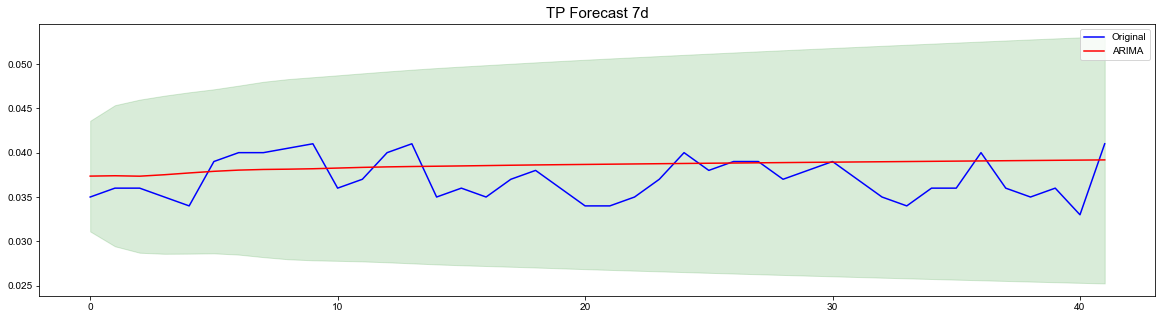

In [68]:
""" Prediction Curve """
plt.figure(figsize=(20, 5))
plt.plot(temp_test.values, label='Original', color='blue')
plt.plot(arima.forecast(42)[0], label='ARIMA', color='red')
plt.fill_between(
    range(temp_test.shape[0]),
    arima.forecast(42)[0]-arima.forecast(42)[1],
    arima.forecast(42)[0]+arima.forecast(42)[1],
    color='g',
    alpha=0.15
)
plt.legend(loc='best')
plt.title('{} Forecast 7d'.format(INDEX), fontsize=15)
plt.show()

+ 预测最大误差率

In [69]:
np.max(abs(temp_test.values-arima.forecast(43)[0])/temp_test.values)

0.18804835286547336

### >>>>>>  Problems

 1. p & q 
 2. 预测数据平滑的原因
 3. 工程化的问题